In [23]:
import os
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import glob
import pickle
import scipy.stats as ss
import time
import copy
import bilby
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

%matplotlib inline

import lalsimulation as lalsim
import lal
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from bilby.gw.prior import BBHPriorDict
from bilby.gw.source import lal_binary_black_hole


def get_gwpy_mean_psd (psd_data, fs = 4096, 
                      fftlength=32,
                      low_frequency = 16,
                      method = 'welch'):
    psd = psd_data.psd(fftlength=fftlength,overlap=0.0,method=method)
    return np.array(psd.frequencies), np.array(psd.value)

In [24]:
from tqdm.auto import trange

In [25]:
def pe_on_grid (inj_idx,
                 theta, 
                 injections,
                 analysis_data_frame,
                 analysis_data_channel,
                 psd_data_frame,
                 psd_data_channel,
                 psd_file,
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size = 300,
                 geocent_time_correction = 0
        ):

    injection_parameters = injections.iloc[inj_idx].to_dict()
    injection_parameters['geocent_time'] =  injection_parameters['geocent_time'] + geocent_time_correction
    param_dict = injection_parameters

    mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
    z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])
    mass_ratio_inj = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])

    trigger_time= injections['geocent_time'][inj_idx]
    premerger_duration = duration - postmerger_duration
    start_time = trigger_time - premerger_duration
    end_time   = start_time + duration
    psd_start_time = start_time + 8
    psd_end_time = psd_start_time + psd_duration
    #trigger_time = end_time - 1

    if analysis_data_channel == None:
        analysis_data = TimeSeries.read(
            analysis_data_frame, 
            start = start_time, 
            end = end_time
        )
    else:
        analysis_data = TimeSeries.read(
            analysis_data_frame, 
            analysis_data_channel,
            start = start_time, 
            end = end_time
        )

    waveform_arguments=dict(minimum_frequency=10.0)
    params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
    chirp_time = lalsim.SimInspiralChirpTimeBound(
        10,
        params_new["mass_1"] * lal.MSUN_SI,
        params_new["mass_2"] * lal.MSUN_SI,
        params_new["a_1"] * np.cos(params_new["tilt_1"]),
        params_new["a_2"] * np.cos(params_new["tilt_2"]),
    )
    chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=chirp_time,
        sampling_frequency=sampling_frequency,
        start_time=injection_parameters["geocent_time"] + 0.2 - chirp_time,
        # the 0.2 is because it has been used in the original injections
        frequency_domain_source_model=lal_binary_black_hole,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(minimum_frequency=10.0),
    )

    ifos = bilby.gw.detector.InterferometerList([det])
    ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
    
    if not os.path.exists(psd_file):
        # first make it exist!
        if psd_data_frame is not None:
            if psd_data_channel == None:
                psd_data = TimeSeries.read(
                    psd_data_frame, 
                    start = psd_start_time, 
                    end = psd_end_time
                )
            else:
                psd_data = TimeSeries.read(
                    psd_data_frame, psd_data_channel, 
                    start = psd_start_time, 
                    end = psd_end_time
                )

            psd_gwpy = get_gwpy_mean_psd (
                psd_data, 
                fs = sampling_frequency, 
                low_frequency=minimum_frequency,
                fftlength=32, 
                method = 'welch'
            )

            np.savetxt(
                fname = psd_file, 
                X = np.array([ psd_gwpy[0][:-1], psd_gwpy[1][:-1] ]).T
            )
    
    
    ifos[0].power_spectral_density.psd_file = psd_file

    priors = BBHPriorDict()
    # First, set all the priors to the injected values, no widths at all for any parameter.
    priors['chirp_mass']  = mc_inj
    priors['mass_ratio']  = mass_ratio_inj
    for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
                'dec', 'phase', 'theta_jn', 'luminosity_distance', 'geocent_time']:
        priors[key] = injection_parameters[key]

    # Next, rewrite the prior for the search parameter with a prior width.  
    if theta == "chirp_mass":
        theta_min = max(5, mc_inj - 0.05)
        theta_max = min(90, mc_inj + 0.05)

        priors[theta]  = bilby.core.prior.Uniform(name=theta, minimum=theta_min, maximum=theta_max, unit='$M_{\odot}$', boundary='reflective')

    if theta == "mass_ratio":
        theta_min = mass_ratio_inj - 0.05
        theta_max = mass_ratio_inj + 0.05
        
        priors[theta]  = bilby.core.prior.Uniform(name=theta, 
                            minimum=max(0.5, theta_min), 
                            maximum=min(1, theta_max), 
                            boundary='reflective')
    
    if (theta == "a_1") | (theta == "a_2"):
        theta_min = injection_parameters[theta] - 0.03
        theta_max = injection_parameters[theta] + 0.03

        priors[theta]  = bilby.core.prior.Uniform(name=theta, 
                            minimum=max(0.0, theta_min), 
                            maximum=min(0.9, theta_max), 
                            boundary='reflective')

    if (theta == "phi_12") | (theta == "phi_jl")| (theta == "psi")| (theta == "phase")| (theta == "ra"):
        theta_min = injection_parameters[theta] - 0.1
        theta_max = injection_parameters[theta] + 0.1

        priors[theta]  = bilby.core.prior.Uniform(name=theta, 
                            minimum=max(0.0, theta_min), 
                            maximum=min(2*np.pi, theta_max), 
                            boundary='periodic')

    if (theta == "dec") | (theta == "theta_jn")| (theta == "tilt_1")| (theta == "tilt_2"):
        theta_min = injection_parameters[theta] - 0.1
        theta_max = injection_parameters[theta] + 0.1

        priors[theta]  = bilby.core.prior.Uniform(name=theta, 
                            minimum=max(0.0, theta_min), 
                            maximum=min(np.pi, theta_max), 
                            boundary='periodic')


    if (theta == "luminosity_distance"):
        theta_min = injection_parameters[theta] - 5
        theta_max = injection_parameters[theta] + 5

        priors[theta]  = bilby.core.prior.Uniform(name=theta, 
                            minimum=max(1, theta_min), 
                            maximum=min(100, theta_max), 
                            boundary='reflective')
        
    likelihood = bilby.gw.GravitationalWaveTransient(
            interferometers=ifos, 
            waveform_generator=waveform_generator,
            reference_frame= 'sky',
            time_reference= 'geocent',
            time_marginalization = False,
            distance_marginalization = False, 
            jitter_time= False,
            phase_marginalization = False,
            priors = priors)    

    
    
    grid = np.linspace(priors[theta].minimum, priors[theta].maximum,grid_size)
    LLR  = np.zeros(grid.shape)

    if theta == 'chirp_mass':
        theta_inj = mc_inj
        for i in trange(len(LLR)):
            mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(grid[i],mass_ratio_inj)
            m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio_inj, mtot)
            param_dict['mass_1'] = m1
            param_dict['mass_2'] = m2
            likelihood.parameters = param_dict

            LLR[i] = likelihood.log_likelihood_ratio()

    if theta == 'mass_ratio':
        theta_inj = mass_ratio_inj
        for i in trange(len(LLR)):
            mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_inj, grid[i])
            m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(grid[i], mtot)
            param_dict['mass_1'] = m1
            param_dict['mass_2'] = m2
            likelihood.parameters = param_dict

            LLR[i] = likelihood.log_likelihood_ratio()

    if (theta != "chirp_mass") and (theta != "mass_ratio"):
        theta_inj = injection_parameters[theta]
        for i in trange(len(LLR)):
            param_dict[theta] = grid[i]
            likelihood.parameters = param_dict

            LLR[i] = likelihood.log_likelihood_ratio()


    return grid, np.exp(LLR-max(LLR)), theta_inj


In [26]:
datadir = "/home/weizmann.kiendrebeogo/DeepClean/DeepClean_CIT/Friday_Work/data"
dc_noise_only        = os.path.join(datadir, 'deepclean-NoiseOnly.gwf')
dc_noise_plus_signal = os.path.join(datadir, 'deepclean-NoisePlusSignal.gwf')
org_noise_only       = os.path.join(datadir, 'original-NoiseOnly.h5')
org_noise_plus_signal= os.path.join(datadir, 'original-NoisePlusSignal.h5')
signal_only          = os.path.join(datadir, 'GW_injected_signal.hdf5')
inj_file             = os.path.join(datadir, 'INJ-1265127585-4096.csv')
inj_file_json        = os.path.join(datadir, 'INJ-1265127585-4096.json')


channel = 'V1:Hrec_hoft_raw_20000Hz'  # Original Channel channel
channel_DC="V1:Hrec_hoft_raw_20000Hz_DC"  # Cleanning channel
channel_INJ = "V1:DC_INJ"                # Injected GW signal channel

injections = pd.read_csv(inj_file)


In [27]:
injections

,Unnamed: 0,mass_1,mass_2,luminosity_distance,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,dec,ra,theta_jn,psi,phase,geocent_time
0,0,21.657061,8.942829,20.337186,0.316401,0.421803,0.0,0.0,0.0,0.0,1.372350,0.351124,1.571572,1.093520,4.623716,1.265128e+09
1,1,17.544304,10.600881,29.596042,0.771905,0.188531,0.0,0.0,0.0,0.0,0.038757,3.129534,2.167390,0.874952,5.544598,1.265128e+09
2,2,18.290719,10.537260,21.154880,0.877212,0.908567,0.0,0.0,0.0,0.0,0.258815,4.949516,1.682590,0.478230,5.549510,1.265128e+09
3,3,16.838082,13.765906,19.765857,0.567760,0.365852,0.0,0.0,0.0,0.0,0.019673,4.494605,0.856310,0.637793,4.287117,1.265128e+09
4,4,19.579346,10.257479,16.910476,0.258311,0.717408,0.0,0.0,0.0,0.0,0.849165,1.901740,2.322145,2.245926,1.694800,1.265128e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,18.632911,10.719888,19.200438,0.697003,0.673823,0.0,0.0,0.0,0.0,-0.906635,1.968273,1.644622,2.709033,0.383454,1.265132e+09
124,124,19.045053,11.166912,26.226166,0.524494,0.254161,0.0,0.0,0.0,0.0,0.636787,1.319891,0.776720,0.102622,2.239597,1.265132e+09
125,125,18.719389,8.516774,26.472437,0.345161,0.712868,0.0,0.0,0.0,0.0,-0.680273,0.548604,1.571081,1.923266,0.022102,1.265132e+09
126,126,20.464251,8.719971,28.141396,0.650938,0.067115,0.0,0.0,0.0,0.0,0.942930,3.119290,1.293614,2.005906,3.245518,1.265132e+09


In [40]:
max(injections['luminosity_distance'])

29.967197408353638

In [ ]:
min

In [8]:
offsets = np.genfromtxt("./offsets.txt")

## Run pe for all parameters on noise-only injections

In [15]:
param_list = ['chirp_mass','mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']

param_list_short = ['phase', 'theta_jn']

for inj_idx in trange(1,128):
    
    posteriors = {}
    for parameter in param_list:

        results = pe_on_grid (inj_idx = inj_idx,
                 theta = parameter, 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = offsets[inj_idx]
        )
        
        posteriors['grid_'+parameter] = results[0]
        posteriors['pdf_'+parameter] = results[1]
        posteriors['inj_'+parameter] = results[2]
    
    with open(f'./posteriors/zero_noise/results_{inj_idx}.pkl', 'wb') as file:
        pickle.dump(posteriors, file)
        




  0%|          | 0/127 [00:00<?, ?it/s]

17:14 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:14 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:14 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:14 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:14 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:14 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:15 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:15 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:15 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:17 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:17 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:17 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:17 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:17 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:18 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:18 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:18 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:19 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:19 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:19 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:20 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:21 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:21 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:21 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:22 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:22 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:22 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:23 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:23 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:23 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:24 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:25 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:25 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:25 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:26 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:26 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:26 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:27 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:27 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:27 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:27 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:28 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:29 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:29 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

17:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:30 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


ValueError: maximum 0.4851505805166051 <= minimum 0.5 for Uniform prior on mass_ratio

In [11]:
with open("posteriors/zero_noise/results_1.pkl", 'rb') as file:
    loaded_data = pickle.load(file)

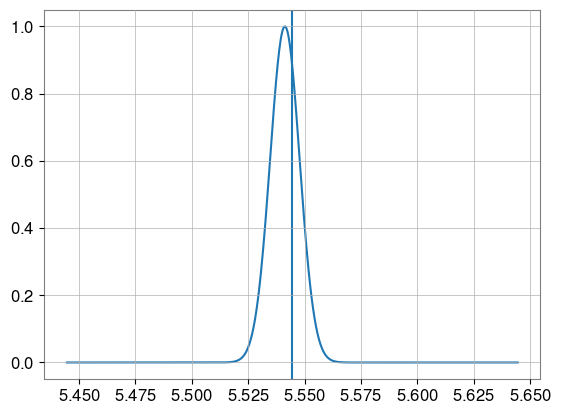

In [14]:
plt.plot(loaded_data['grid_phase'], loaded_data['pdf_phase'])
plt.axvline(loaded_data['inj_phase'])

In [ ]:
param_list = ['chirp_mass','mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']

param_list_short = ['phase', 'theta_jn']

for inj_idx in trange(1,128):
    
    posteriors = {}
    for parameter in param_list:

        results = pe_on_grid (inj_idx = inj_idx,
                 theta = parameter, 
                 injections = injections,
                 analysis_data_frame = org_noise_plus_signal,
                 analysis_data_channel = channel,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = offsets[inj_idx]
        )
        
        posteriors['grid_'+parameter] = results[0]
        posteriors['pdf_'+parameter] = results[1]
        posteriors['inj_'+parameter] = results[2]
    
    with open(f'./posteriors/unclean/results_{inj_idx}.pkl', 'wb') as file:
        pickle.dump(posteriors, file)
        




In [ ]:
param_list = ['chirp_mass','mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']

param_list_short = ['phase', 'theta_jn']

for inj_idx in trange(1,128):
    
    posteriors = {}
    for parameter in param_list:

        results = pe_on_grid (inj_idx = inj_idx,
                 theta = parameter, 
                 injections = injections,
                 analysis_data_frame = dc_noise_plus_signal,
                 analysis_data_channel = channel_DC,
                 psd_data_frame = dc_noise_only,
                 psd_data_channel = channel_DC,
                 psd_file = './gwpy_psd_deepclean.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = offsets[inj_idx]
        )
        
        posteriors['grid_'+parameter] = results[0]
        posteriors['pdf_'+parameter] = results[1]
        posteriors['inj_'+parameter] = results[2]
    
    with open(f'./posteriors/deepclean/results_{inj_idx}.pkl', 'wb') as file:
        pickle.dump(posteriors, file)
        




## check all posteriors for injection 1

In [17]:
with open(f'./posteriors/zero_noise/results_1.pkl', 'rb') as file:
        results = pickle.load(file)


In [18]:
results

{'grid_chirp_mass': array([11.74793626, 11.74810321, 11.74827015, ..., 11.84760237,
        11.84776932, 11.84793626]),
 'pdf_chirp_mass': array([1.54251177e-191, 2.77458141e-190, 4.95079452e-189, ...,
        3.58860406e-207, 1.99054462e-208, 1.09648982e-209]),
 'inj_chirp_mass': 11.797936263702484,
 'grid_mass_ratio': array([0.5542349 , 0.55440184, 0.55456879, ..., 0.65390101,
        0.65406795, 0.6542349 ]),
 'pdf_mass_ratio': array([0., 0., 0., ..., 0., 0., 0.]),
 'inj_mass_ratio': 0.6042348975192453,
 'grid_a_1': array([0.74190465, 0.74200482, 0.74210499, ..., 0.80170432,
        0.80180449, 0.80190465]),
 'pdf_a_1': array([0., 0., 0., ..., 0., 0., 0.]),
 'inj_a_1': 0.7719046521864085,
 'grid_a_2': array([0.15853129, 0.15863146, 0.15873163, ..., 0.21833096,
        0.21843113, 0.21853129]),
 'pdf_a_2': array([0., 0., 0., ..., 0., 0., 0.]),
 'inj_a_2': 0.1885312934906662,
 'grid_tilt_1': array([0.        , 0.00016694, 0.00033389, ..., 0.09966611,
        0.09983306, 0.1       ]),


In [19]:
param_list

['chirp_mass',
 'mass_ratio',
 'a_1',
 'a_2',
 'tilt_1',
 'tilt_2',
 'phi_12',
 'phi_jl',
 'psi',
 'ra',
 'dec',
 'phase',
 'theta_jn',
 'luminosity_distance']

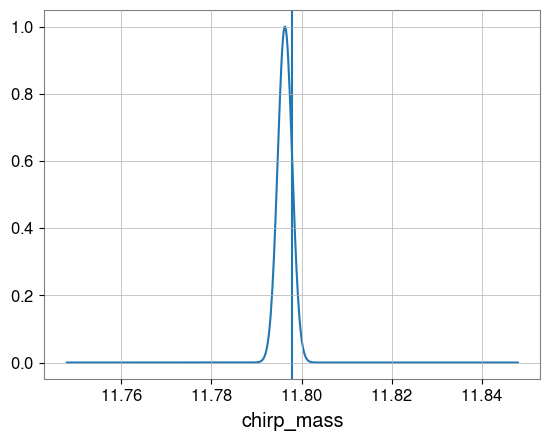

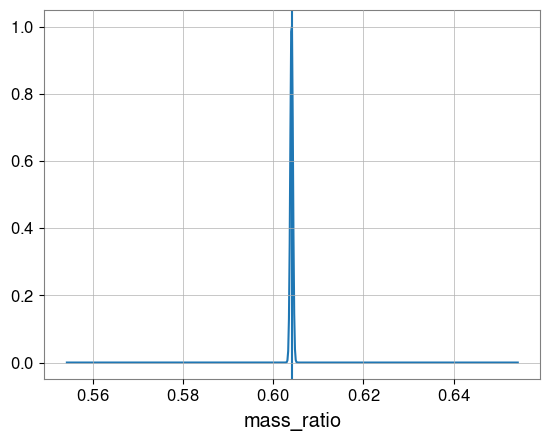

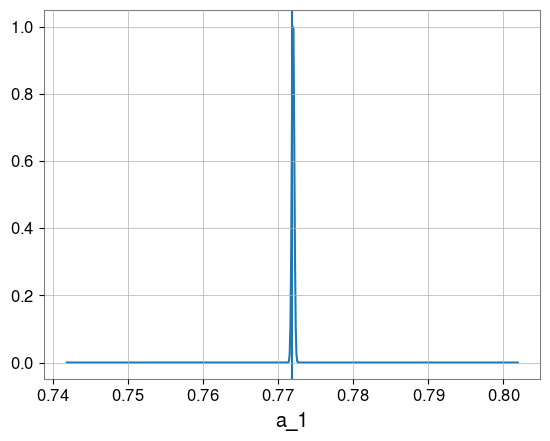

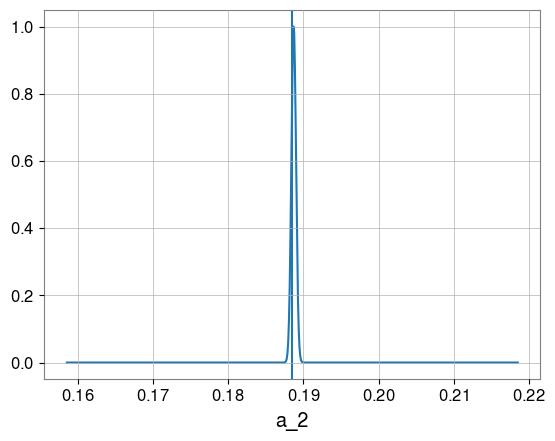

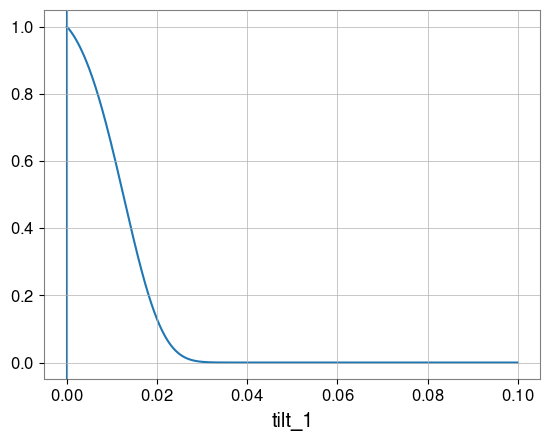

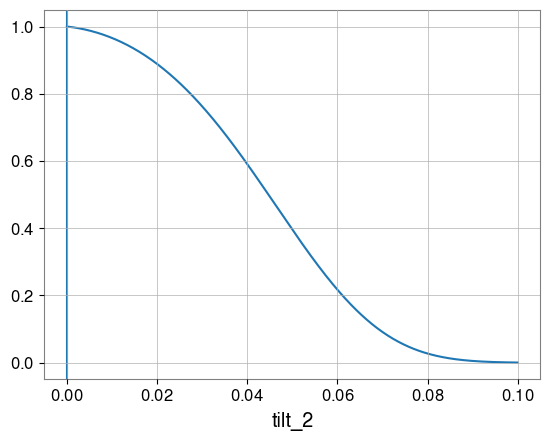

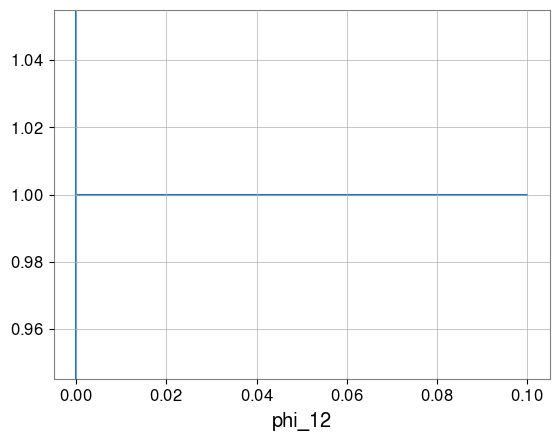

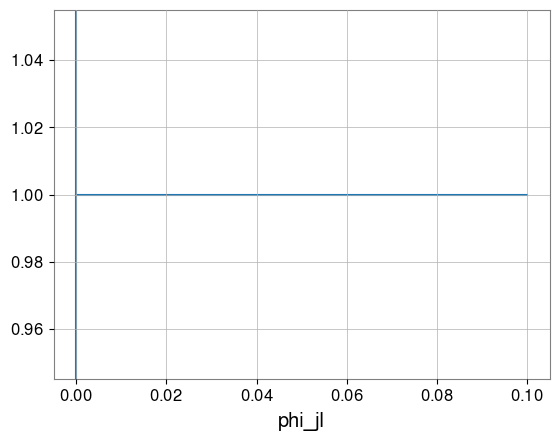

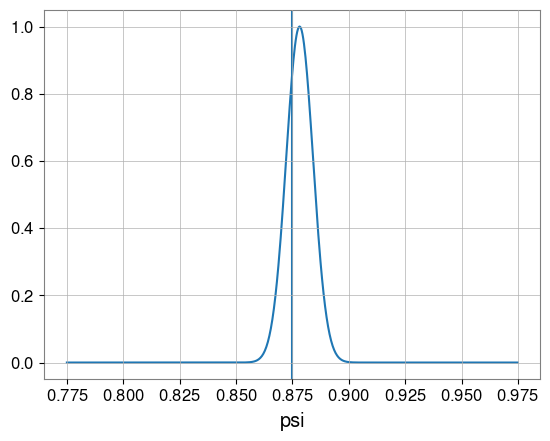

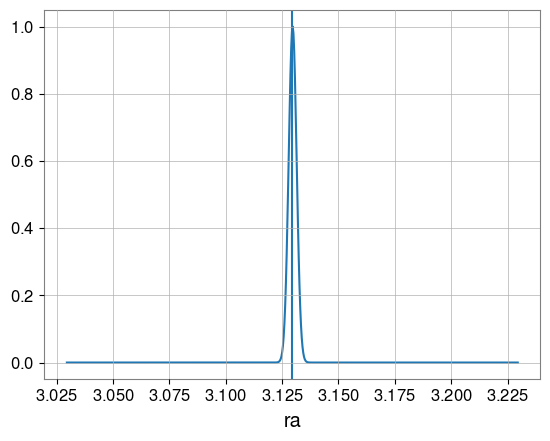

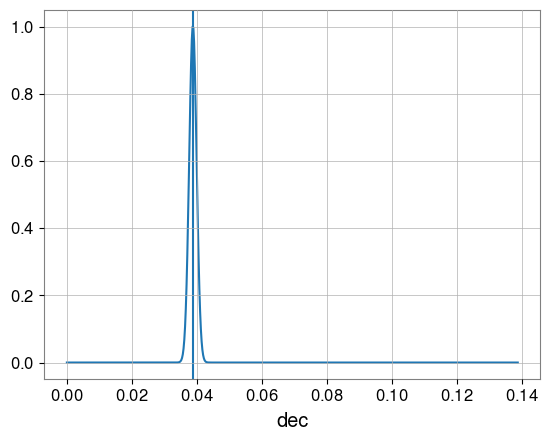

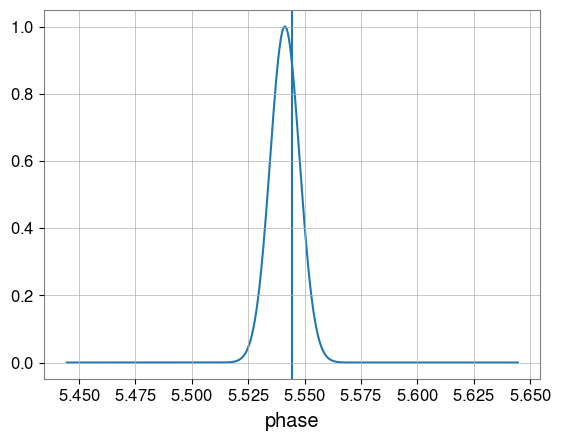

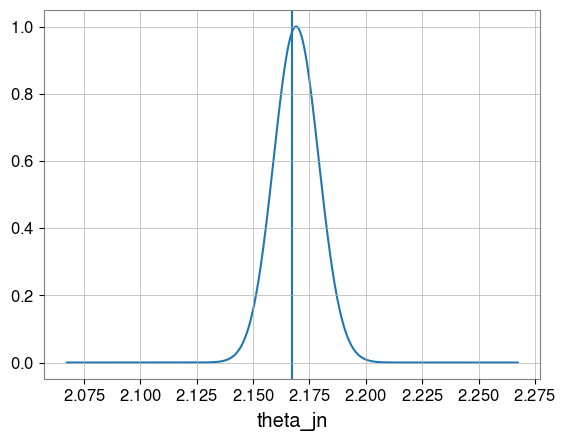

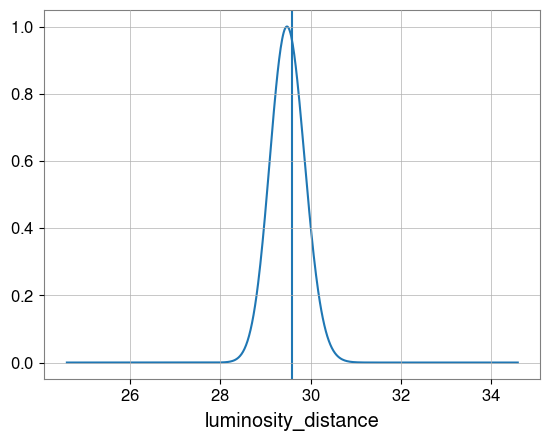

In [20]:
for param in param_list:
    plt.figure()
    plt.plot(results['grid_'+param], results['pdf_'+param] )
    plt.axvline(results['inj_'+param])
    plt.xlabel(param)

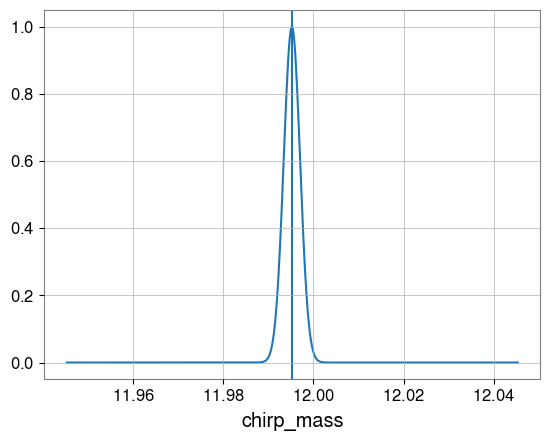

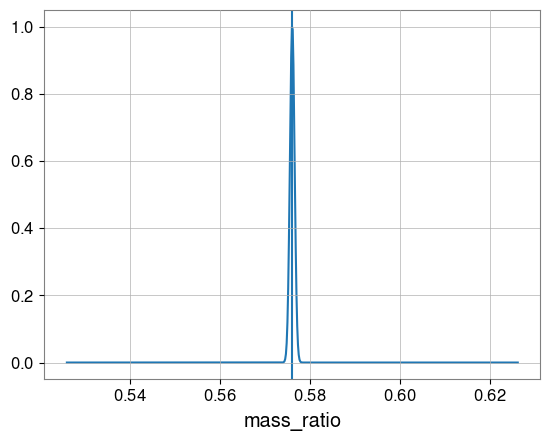

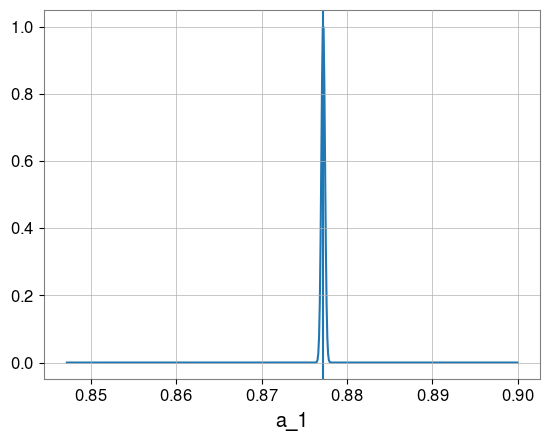

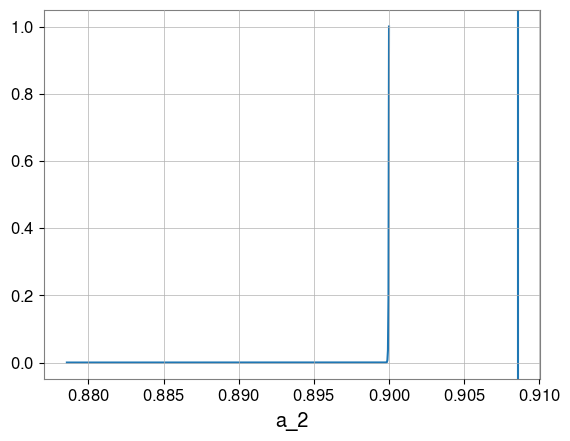

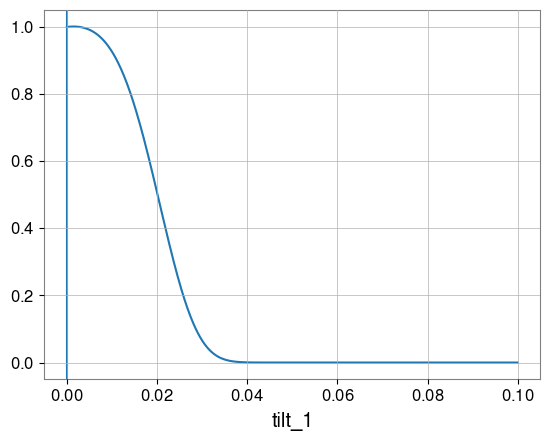

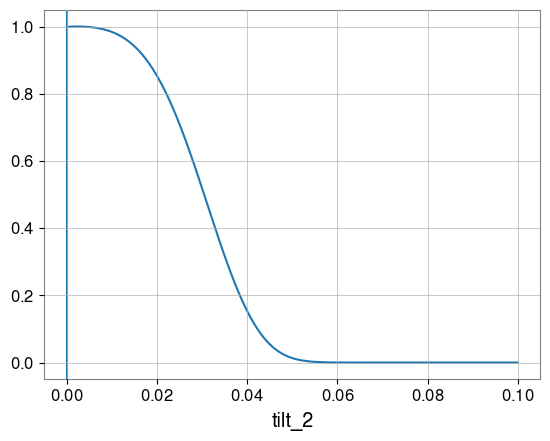

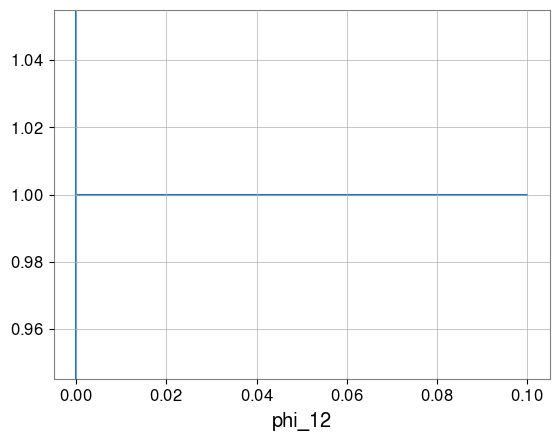

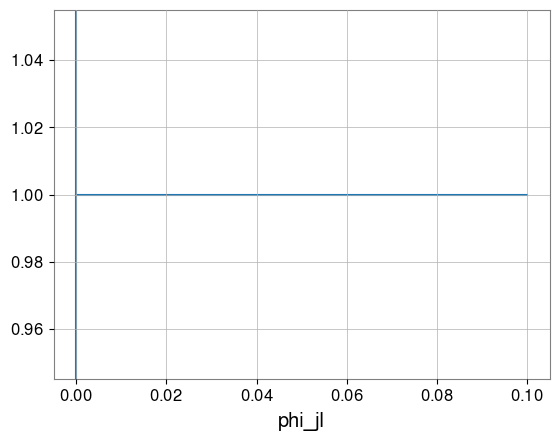

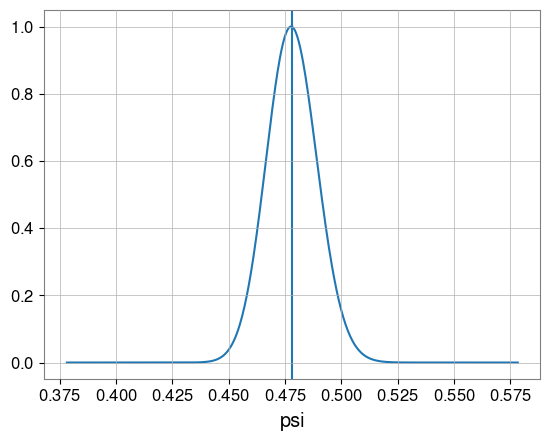

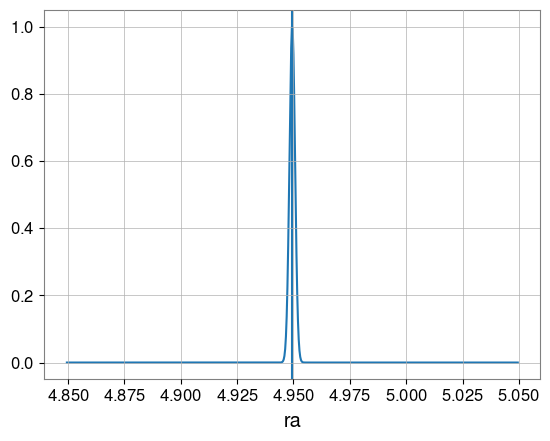

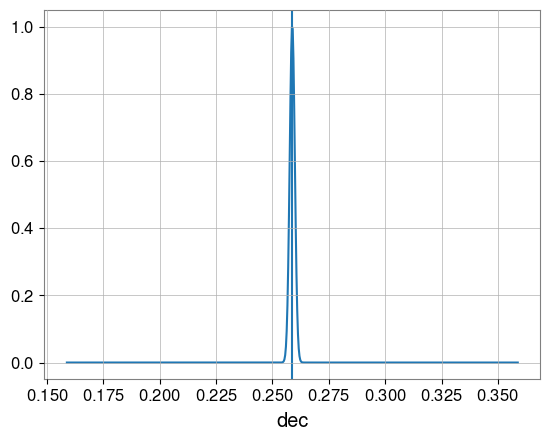

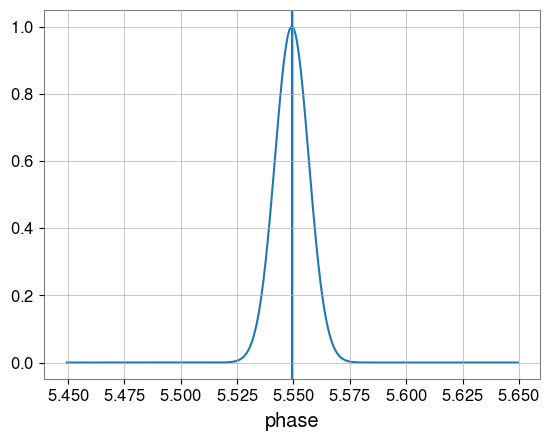

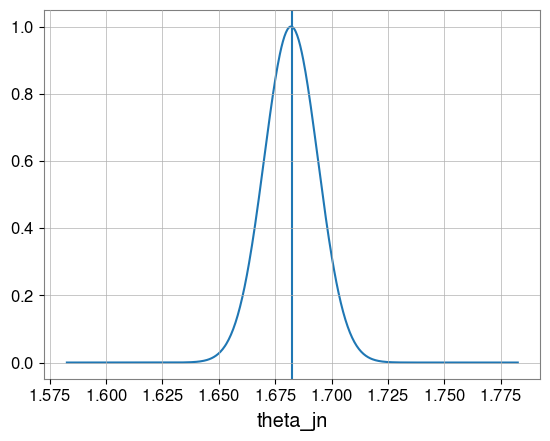

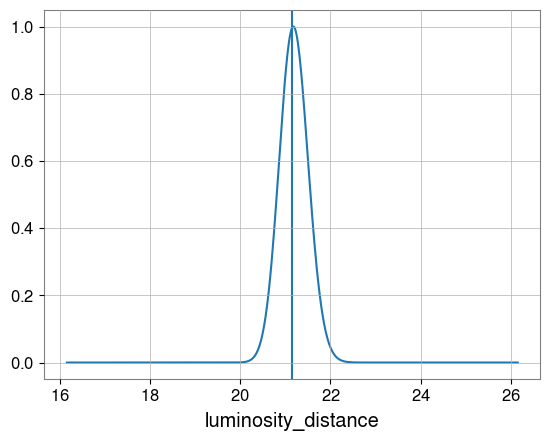

In [21]:
with open(f'./posteriors/zero_noise/results_2.pkl', 'rb') as file:
        results = pickle.load(file)
        
for param in param_list:
    plt.figure()
    plt.plot(results['grid_'+param], results['pdf_'+param] )
    plt.axvline(results['inj_'+param])
    plt.xlabel(param)

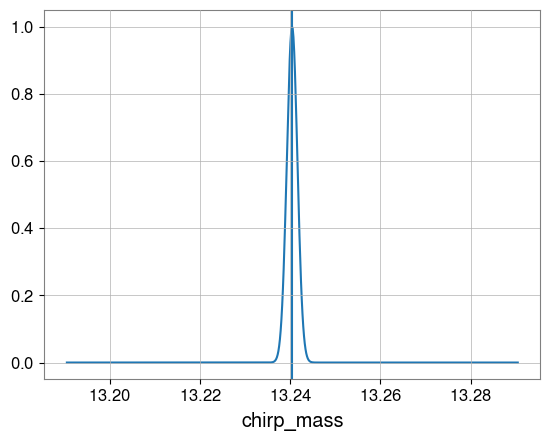

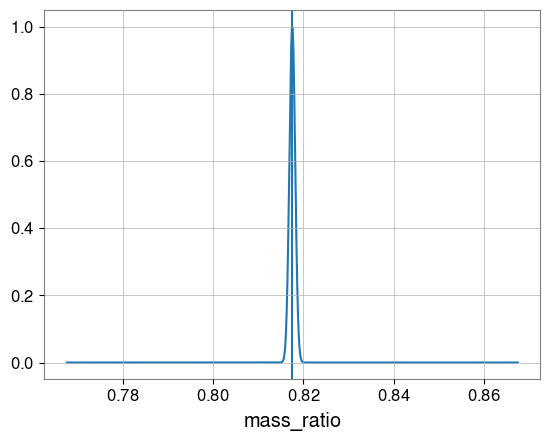

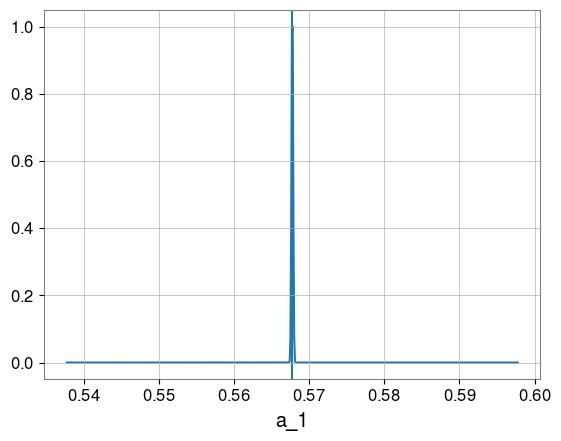

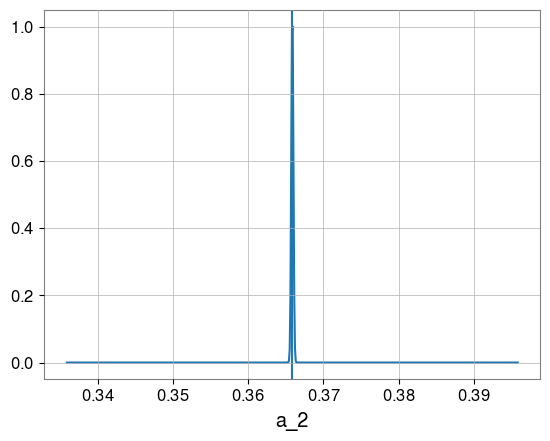

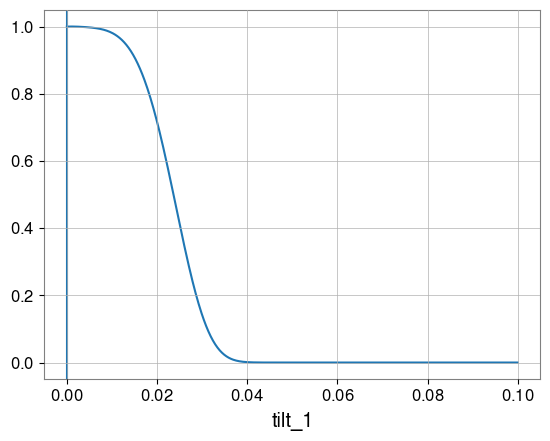

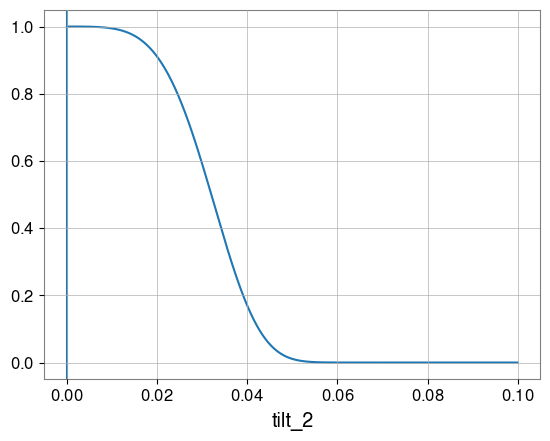

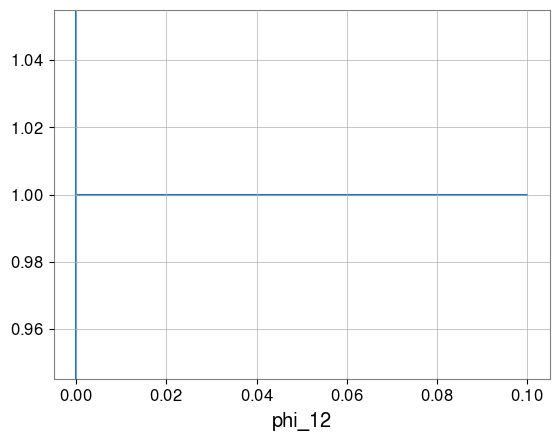

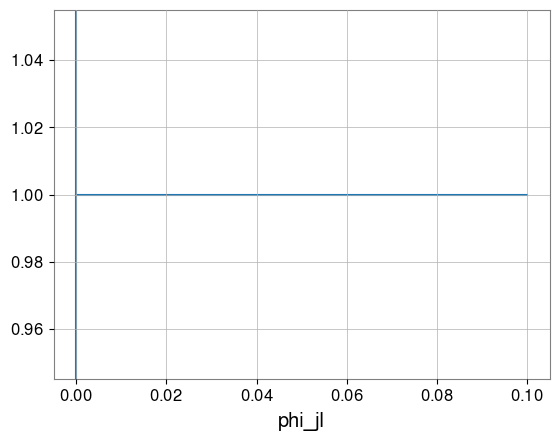

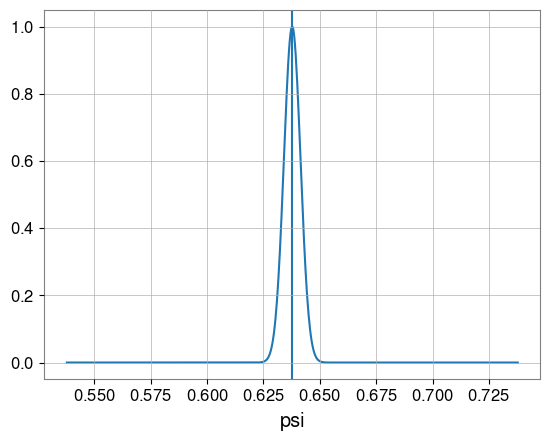

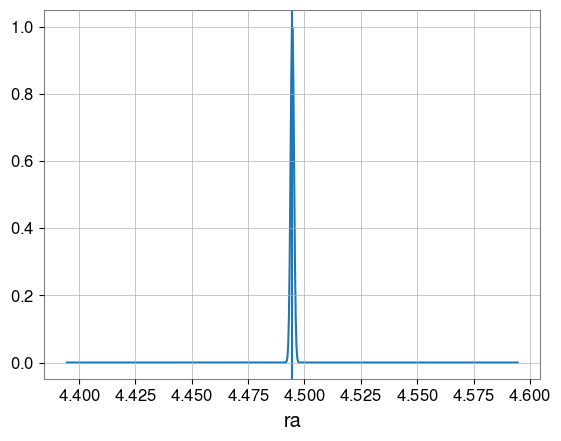

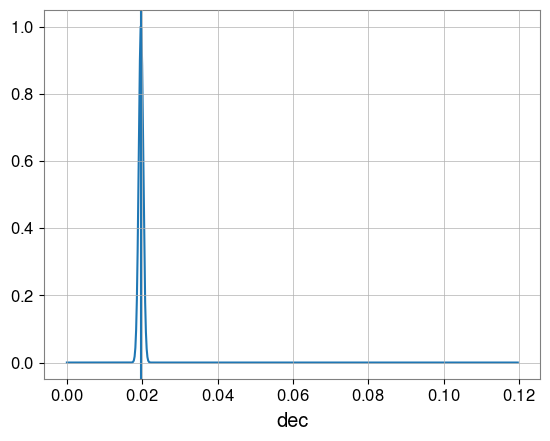

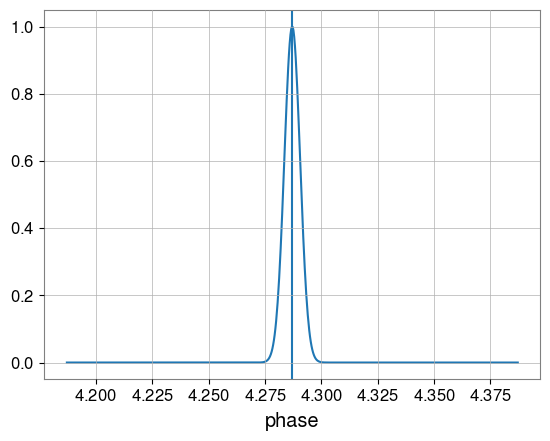

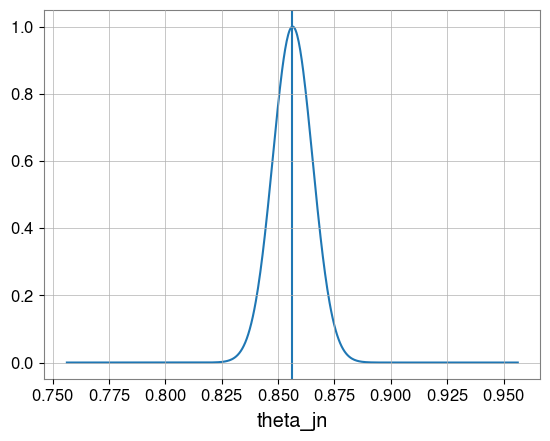

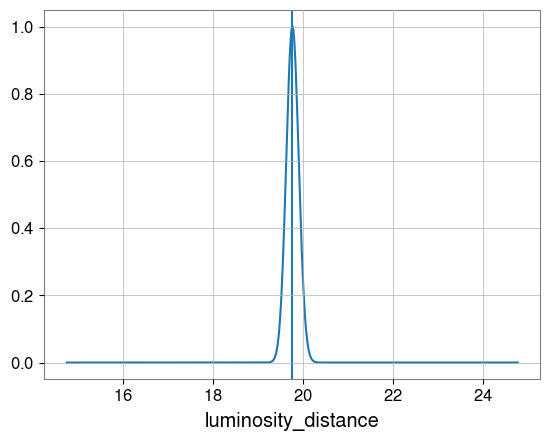

In [22]:
with open(f'./posteriors/zero_noise/results_3.pkl', 'rb') as file:
        results = pickle.load(file)
        
for param in param_list:
    plt.figure()
    plt.plot(results['grid_'+param], results['pdf_'+param] )
    plt.axvline(results['inj_'+param])
    plt.xlabel(param)